In [1]:
import cv2 as cv
import numpy as np

from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
%matplotlib inline

import pysight

In [2]:
# Trying to see if multiple displays will plot
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

###### Helpers

In [3]:
def cv2mpl(frame, color=False):
    """Helper function to convert a BGR img to RGB and display using Matplotlib.
    color (cv.COLOR_)
        cv.COLOR_BGR2RGB for normal webcam photos
        cv.COLOR_BGR2GRAY for normal to grey
        cv.COLOR_GRAY2RGB for grey to image
    """
    final_frame = cv.cvtColor(frame, color) if color else frame
    fig = imshow(final_frame)
    return fig

    
def crop_photo(frame, dim):
    """Helper function to crop a photo from given dimensions."""
    x,y,w,h = dim
    return frame[y:y+h, x:x+w]


def get_left_eye(eyes):
    """Helper function to get the left eye.
    Eyes: n * [x, y, w, h] for each eye detected in photo."""
    left_idx, left_val = -1, float('inf')
    
    for idx, val in enumerate(eyes):
        if val[0] < left_val:
            left_val = val[0]
            left_idx = idx
    
    return eyes[left_idx]


def draw_circle(frame, x, y, radius):
    img_copy = frame.copy()
    cv.circle(img_copy, (int(x), int(y)), radius, (255,255,255))
    return img_copy

---

###### Classifiers

In [4]:
face_clf = cv.CascadeClassifier('pysight/models/haarcascade_frontalface_alt.xml')
eyes_clf = cv.CascadeClassifier('pysight/models/haarcascade_eye.xml')

##### Preprocessing

In [5]:
%ls -1 tests/test_imgs/

eye-double.jpg
eye-single.jpg
webcam-bad-eyes.jpg
webcam-bad-face.jpg
webcam-multiple.jpg
webcam-single-00.jpg
webcam-single-01.png


In [6]:
test_img = cv.imread('tests/test_imgs/webcam-single-01.png') #00.jpg

print ("orig dim:\t{}".format(test_img.shape))

test_img_proc_scale = pysight.Camera().process(test_img, 2)
test_img_proc_nscale = pysight.Camera().process(test_img, 1)

print ("proc scale dim:\t{}".format(test_img_proc_scale.shape))
print ("proc NO scale dim:\t{}".format(test_img_proc_nscale.shape))


# Regular image
#cv2mpl(test_img, cv.COLOR_BGR2RGB) 

# Greyscale image
#cv2mpl(test_img_proc_scale, cv.COLOR_GRAY2RGB)

orig dim:	(378, 669, 3)
proc scale dim:	(189, 334)
proc NO scale dim:	(378, 669)


Test our face classifier

[[289  42 206 206]
 [ 82 136  63  63]]


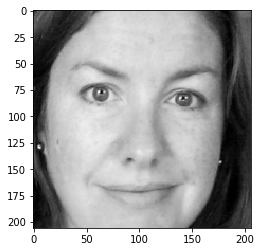

In [7]:
faces = face_clf.detectMultiScale(test_img_proc_nscale, scaleFactor=1.03, minNeighbors=5, flags=0, minSize=(30, 30))
print (faces)

test_face = crop_photo(test_img_proc_nscale, faces[0])
cv2mpl(test_face, cv.COLOR_GRAY2RGB)

Eyes Classifier

In [8]:
eyes = eyes_clf.detectMultiScale(test_face, 1.1, 2, 0, (30, 30))
print (eyes)

left = get_left_eye(eyes)
l_eye = crop_photo(test_face, left)
r_eye = crop_photo(test_face, eyes[1])

#cv2mpl(crop_photo(test_face, eyes[1]),  cv.COLOR_GRAY2RGB)

[[ 35  52  52  52]
 [117  59  50  50]]


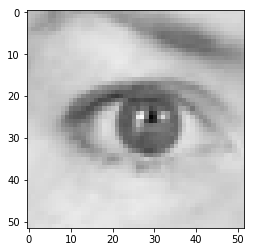

In [9]:
cv2mpl(l_eye, cv.COLOR_GRAY2RGB)

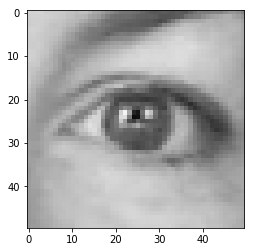

In [10]:
cv2mpl(r_eye, cv.COLOR_GRAY2RGB)

In [11]:
pt = pysight.PupilTools()

(29, 26)


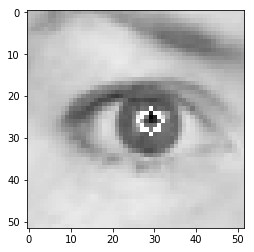

In [17]:
l_center = find_pupil_noscale(l_eye)
l_viz = draw_circle(l_eye, l_center[0], l_center[1], 3)

print (l_center)
cv2mpl(l_viz, cv.COLOR_GRAY2RGB)

(27, 27)


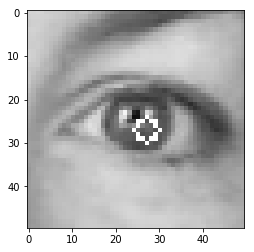

In [16]:
r_center = find_pupil_noscale(r_eye)
r_viz = draw_circle(r_eye, r_center[0], r_center[1], 3)

print (r_center)
cv2mpl(r_viz, cv.COLOR_GRAY2RGB)

---

#### PyLike

In [ ]:
import math
from scipy.misc import toimage
import time
from queue import *

# test a possible center (x,y) are coors of possible
# center and gx and gy are the x and y components
# of the gradient of some other point x.
K_WEIGHT_DIVISOR = 1.0
K_FAST_WIDTH = 50
K_GRADIENT_THRESHOLD = 50.0
K_WEIGHT_BLUR_SIZE = 5
K_THRESHOLD_VALUE = 0.60
K_ENABLE_WEIGHT = True
K_POST_PROCESSING = True

# Helpers
def unscale_point(p, orig):
    px, py = p
    height, width = orig.shape
    ratio = K_FAST_WIDTH/width
    x = int(round(px / ratio))
    y = int(round(py / ratio))
    return (x,y)


def scale_to_fast_size(src):
    rows, cols = src.shape
    return cv.resize(src, (K_FAST_WIDTH, int((K_FAST_WIDTH / cols) * rows)))


def test_possible_centers_formula(x, y, weight, gx, gy, arr):
    rows, cols = np.shape(arr)
    for cy in range(rows):
        for cx in range(cols):
            if x == cx and y == cy:
                continue
            dx = x - cx
            dy = y - cy

            magnitude = math.sqrt((dx * dx) + (dy * dy))
            dx = dx / magnitude
            dy = dy / magnitude
            dot_product = dx * gx + dy * gy
            dot_product = max(0.0, dot_product)
            if K_ENABLE_WEIGHT == True:
                arr[cy][cx] += dot_product * dot_product * (weight[cy][cx]/K_WEIGHT_DIVISOR)
            else:
                arr[cy][cx] += dot_product * dot_product
    return arr


def matrix_magnitude(mat_x, mat_y):
    rows, cols = np.shape(mat_x)
    res_arr = np.zeros((rows, cols))
    for y in range(rows):
        for x in range(cols):
            gX = mat_x[y][x]
            gY = mat_y[y][x]
            magnitude = math.sqrt((gX * gX) + (gY * gY))
            res_arr[y][x] = magnitude
    return res_arr


def compute_dynamic_threshold(mags_mat, std_dev_factor):
    mean_magn_grad, std_magn_grad = cv.meanStdDev(mags_mat)
    rows, cols = np.shape(mags_mat)
    stddev = std_magn_grad[0] / math.sqrt(rows * cols)
    return std_dev_factor * stddev + mean_magn_grad[0]


def flood_should_push_point(dir, mat):
    px, py = dir
    rows, cols = np.shape(mat)
    if px >= 0 and px < cols and py >= 0 and py < rows:
        return True
    else:
        return False


def flood_kill_edges(mat):
    rows, cols = np.shape(mat)
    cv.rectangle(mat, (0,0), (cols, rows), 255)
    mask = np.ones((rows, cols), dtype=np.uint8)
    mask = mask * 255
    to_do = Queue()
    to_do.put((0,0))
    while to_do.qsize() > 0:
        px,py = to_do.get()
        if mat[py][px] == 0:
            continue
        right = (px + 1, py)
        if flood_should_push_point(right, mat):
            to_do.put(right)
        left = (px - 1, py)
        if flood_should_push_point(left, mat):
            to_do.put(left)
        down = (px, py + 1)
        if flood_should_push_point(down, mat):
            to_do.put(down)
        top = (px, py - 1)
        if flood_should_push_point(top, mat):
            to_do.put(top)
        mat[py][px] = 0.0
        mask[py][px] = 0
    return mask


def compute_mat_x_gradient(mat): 
    rows, cols = mat.shape
    out = np.zeros((rows, cols), dtype='float64')
    mat = mat.astype(float)
    for y in range(rows):
        out[y][0] = mat[y][1] - mat[y][1]
        for x in range(cols - 1):
            out[y][x] = (mat[y][x+1] - mat[y][x-1])/2.0
        out[y][cols - 1] = (mat[y][cols - 1] - mat[y][cols - 2])
    return out



def find_eye_center(img):
    # get row and column lengths
    rows, cols = np.asarray(img).shape

    # scale down eye image to manageable size
    resized = scale_to_fast_size(img)
    resized_arr = np.asarray(resized)
    res_rows, res_cols = np.shape(resized_arr)

    # compute gradients for x and y components of each point
    grad_arr_x = compute_mat_x_gradient(resized_arr)
    grad_arr_y = np.transpose(compute_mat_x_gradient(np.transpose(resized_arr)))

    # create a matrix composed of the magnitudes of the x and y gradients
    mags_mat = matrix_magnitude(grad_arr_x, grad_arr_y)

    # find a threshold value to get rid gradients that are below gradient threshold
    gradient_threshold = compute_dynamic_threshold(mags_mat, K_GRADIENT_THRESHOLD)
    # and now set those gradients to 0 if < gradient threshold and scale down other
    # gradients

    for y in range(res_rows):
        for x in range(res_cols):
            gX = grad_arr_x[y][x]
            gY = grad_arr_y[y][x]
            mag = mags_mat[y][x]
            if mag > gradient_threshold: 
                grad_arr_x[y][x] = gX/mag
                grad_arr_y[y][x] = gY/mag
            else:
                grad_arr_x[y][x] = 0.0
                grad_arr_y[y][x] = 0.0

    # create a weighted image that has a gausian blur
    weight = cv.GaussianBlur(resized, (K_WEIGHT_BLUR_SIZE, K_WEIGHT_BLUR_SIZE), 0, 0)
    weight_arr = np.asarray(weight)
    weight_rows, weight_cols = np.shape(weight_arr)
    # invert the weight matrix
    for y in range(weight_rows):
        for x in range(weight_cols):
            weight_arr[y][x] = 255-weight_arr[y][x]

    # create a matrix to store the results from test_possible_centers_formula
    out_sum = np.zeros((res_rows, res_cols))
    out_sum_rows, out_sum_cols = np.shape(out_sum)

    # call test_possible_centers for each point
    for y in range(weight_rows):
        for x in range(weight_cols):
            gX = grad_arr_x[y][x]
            gY = grad_arr_y[y][x]
            if gX == 0.0 and gY == 0.0:
                continue
            test_possible_centers_formula(x, y, weight_arr, gX, gY, out_sum)
    # average all values in out_sum and convert to float32. assign to 'out' matrix
    num_gradients = weight_rows * weight_cols
    out = out_sum.astype(np.float32)*(1/num_gradients)
    _, max_val, _, max_p = cv.minMaxLoc(out)
    print (max_p)
    if K_POST_PROCESSING == True:
        flood_thresh = max_val * K_THRESHOLD_VALUE 
        retval, flood_clone = cv.threshold(out, flood_thresh, 0.0, cv.THRESH_TOZERO)
        mask = flood_kill_edges(flood_clone)
        _, max_val, _, max_p = cv.minMaxLoc(out, mask)
        print (max_p)
    x, y = unscale_point(max_p, img)
    return x,y

In [ ]:
l_center = find_eye_center(l_eye)
l_viz = draw_circle(l_eye, l_center[0], l_center[1], 3)

cv2mpl(l_viz, cv.COLOR_GRAY2RGB)

In [ ]:
r_center = find_eye_center(r_eye)
r_viz = draw_circle(r_eye, r_center[0], r_center[1], 3)

cv2mpl(r_viz, cv.COLOR_GRAY2RGB)

---

**Change PyeLike from above**

In [ ]:
# MY GRADIENT FUNCTIONS

In [ ]:
def compute_dynamic_threshold_fast(mags_mat, std_dev_factor):
    mean_magn_grad, std_magn_grad = cv.meanStdDev(mags_mat)
    stddev = std_magn_grad[0] / np.sqrt(mags_mat.size)
    return std_dev_factor * stddev + mean_magn_grad[0]

In [ ]:
#th2 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY,11,2)

def filter_gradients(gradient, magnitudes, threshold):
    threshold_fx = lambda x, mag: x if (mag > threshold) else 0.0
    threshold_mask = np.vectorize(threshold_fx)
    return threshold_mask(gradient, magnitudes)

```
def test_possible_centers_formula(x, y, weight, gx, gy, arr):
    rows, cols = np.shape(arr)
    for cy in range(rows):
        for cx in range(cols):
            if x == cx and y == cy:
                continue
            dx = x - cx
            dy = y - cy

            magnitude = math.sqrt((dx * dx) + (dy * dy))
            dx = dx / magnitude
            dy = dy / magnitude
            dot_product = dx * gx + dy * gy
            dot_product = max(0.0, dot_product)
            if K_ENABLE_WEIGHT == True:
                arr[cy][cx] += dot_product * dot_product * (weight[cy][cx]/K_WEIGHT_DIVISOR)
            else:
                arr[cy][cx] += dot_product * dot_product
    return arr
```    

In [ ]:
def find_eye_center_vector(img):
    start = time.time()
    
    # get row and column lengths
    # TO DO
    rows, cols = np.asarray(img).shape

    # scale down eye image to manageable size
    # TO DO
    resized = scale_to_fast_size(img)
    resized_arr = np.asarray(resized)
    res_rows, res_cols = np.shape(resized_arr)

    # compute gradients for x and y components of each point
    # DONE
    grad_arr_x = cv.Sobel(img, cv.CV_64F, 1, 0, ksize=3)
    grad_arr_y = cv.Sobel(img, cv.CV_64F, 0, 1, ksize=3)
    # create a matrix composed of the magnitudes of the x and y gradients
    # DONE
    mags_mat = np.sqrt(np.square(grad_arr_x) + np.square(grad_arr_y))

    # find a threshold value to get rid gradients that are below gradient threshold
    # DONE
    gradient_threshold = compute_dynamic_threshold_fast(mags_mat, K_GRADIENT_THRESHOLD)
    
    
    # and now set those gradients to 0 if < gradient threshold and scale down other gradients
    # DONEISH
    grad_arr_x = filter_gradients(grad_arr_x, mags_mat, gradient_threshold)
    grad_arr_y = filter_gradients(grad_arr_y, mags_mat, gradient_threshold)
    #ret_thresh_x, grad_arr_x = cv.threshold(grad_arr_x, gradient_threshold, cv.THRESH_TOZERO_INV)
    #ret_thresh_y, grad_arr_y = cv.threshold(grad_arr_y, gradient_threshold, cv.THRESH_TOZERO_INV)
    

    ## DEBUG
    cv2mpl(grad_arr_x)
    

    # create a weighted image that has a gausian blur
    # DONE
    weight = cv.GaussianBlur(resized, (K_WEIGHT_BLUR_SIZE, K_WEIGHT_BLUR_SIZE), 0, 0)
    weight_rows, weight_cols = np.shape(weight)[:2]
    
    # invert the weight matrix
    # DONE
    weight_arr = cv.bitwise_not(weight)


    # create a matrix to store the results from test_possible_centers_formula
    # TO DO
    out_sum = np.zeros((res_rows, res_cols))
    out_sum_rows, out_sum_cols = np.shape(out_sum)
    
    test_out_sum = np.sum()

    # call test_possible_centers for each point
    # TO DO
    
    for y in range(weight_rows):
        for x in range(weight_cols):
            gX = grad_arr_x[y][x]
            gY = grad_arr_y[y][x]
            if gX == 0.0 and gY == 0.0:
                continue
            test_possible_centers_formula(x, y, weight_arr, gX, gY, out_sum)
    
    # average all values in out_sum and convert to float32. assign to 'out' matrix
    # DONE
    num_gradients = weight_arr.size
    
    # TO DO
    out = out_sum.astype(np.float32)*(1/num_gradients)
    _, max_val, _, max_p = cv.minMaxLoc(out)
    print (max_p)
    
    # POST PROCESSING
    if K_POST_PROCESSING == True:
        flood_thresh = max_val * K_THRESHOLD_VALUE 
        retval, flood_clone = cv.threshold(out, flood_thresh, 0.0, cv.THRESH_TOZERO)
        mask = flood_kill_edges(flood_clone)
        _, max_val, _, max_p = cv.minMaxLoc(out, mask)
        print (max_p)
        
    # UNSCALE AND RETURN
    x, y = unscale_point(max_p, img)
    #return x,y
    return time.time() - start

In [ ]:
# 
K_POST_PROCESSING = False

rt_center = find_eye_center_vector(r_eye)
print(rt_center)
#rt_viz = draw_circle(r_eye, rt_center[0], rt_center[1], 3)

#cv2mpl(rt_viz, cv.COLOR_GRAY2RGB)

In [ ]:
# 0.07416415214538574 # up until loop

# 0.09749245643615723 # Commented test_possible centers function

# 10.910849332809448  # full thing

# 21.645119190216064 # Test class, wrong

---

#### EyeTab by [errollw on Github](https://github.com/errollw/EyeTab)

In [14]:
import cv2 as cv
import numpy as np

from time import time

__winname = "Eye Centre (gradients)"
__debug_imgs = {}

__inv_intensity_weight_divisor = 300 #100
__fast_width = 50.0 #25.

# Algorithm from "ACCURATE EYE CENTRE LOCALISATION BY MEANS OF GRADIENTS - Fabian Timm and Erhardt Barth"
# Based on C++ code from https://github.com/trishume/eyeLike

def test_possible_centers_formula(grad_x0, grad_y0, darkness_weight, grad_x_val, grad_y_val, indicies_grid, shape):
    
    dx = np.ones(shape) * grad_x0 - indicies_grid[1]
    dy = np.ones(shape) * grad_y0 - indicies_grid[0]
    magnitudes = cv.magnitude(dx + 0.0001, dy)          # 0.0001 is a hack to offset against division by 0
    dx = dx / magnitudes
    dy = dy / magnitudes
    
    diffs = (dx * grad_x_val + dy * grad_y_val) #* darkness_weight
    diffs[diffs < 0] = 0   
    
    return diffs


def get_center_map(eye_img_grey):
    
    # Compute gradients along X, Y axes
    grad_x_img = cv.Sobel(eye_img_grey, ddepth=cv.CV_64F, dx=1, dy=0, ksize=3)
    grad_y_img = cv.Sobel(eye_img_grey, ddepth=cv.CV_64F, dx=0, dy=1, ksize=3)
    
    # Compute magnitudes of gradients, and the threshold based of mean + std dev
    magnitudes = np.sqrt(grad_x_img ** 2 + grad_y_img ** 2).astype(int)
    mag_thresh = int(np.std(magnitudes) / 2 + np.mean(magnitudes))
    
    # Normalize the gradients based on threshold
    grad_x_img = np.divide(grad_x_img, magnitudes + 1)
    grad_y_img = np.divide(grad_y_img, magnitudes + 1)
    
    # Filter out gradients below threshold
    grad_x_img[magnitudes < mag_thresh] = 0
    grad_y_img[magnitudes < mag_thresh] = 0   
    
    # Invert image for weighting
    #eye_img_inv = 255 - eye_img_grey
    weighted_img = cv.GaussianBlur(eye_img_grey, (5, 5), 0, 0)
    eye_img_inv = cv.bitwise_not(weighted_img) # no change in accuracy
    
    # Normalize the weights
    darkness_weights = eye_img_inv / __inv_intensity_weight_divisor
    
    accumulator = np.zeros(eye_img_grey.shape[:2], dtype=np.float32)
    indicies_grid = np.indices(accumulator.shape[:2])
    indicies_shape = indicies_grid.shape[1:3]
    
    for y in range(eye_img_grey.shape[0]):
        for x in range (eye_img_grey.shape[1]):
            if grad_x_img[y][x] == 0 and grad_y_img[y][x] == 0: continue
            accumulator += test_possible_centers_formula(x, y,
                                                         darkness_weights[y][x],
                                                         grad_x_img[y][x], grad_y_img[y][x],
                                                         indicies_grid, indicies_shape)
    
    num_gradients = eye_img_grey.shape[0] * eye_img_grey.shape[1]
    return accumulator * (1 / num_gradients)


def find_pupil(eye_img_bgr, debug_index=False):
    
    """ Estimates the centre of the pupil using image gradients
    """

    #eye_img_r = cv.split(eye_img_bgr)[2]   # Extract red channel only
    eye_img_r = eye_img_bgr
    
    # Scale to small image for faster computation
    scale = __fast_width / eye_img_bgr.shape[0]
    small_size = (int((__fast_width / eye_img_bgr.shape[0]) * eye_img_bgr.shape[1]), int(__fast_width))
    eye_img_small = cv.resize(eye_img_r, small_size)
    
    center_map = get_center_map(eye_img_small)
    
    max_val_index = np.argmax(center_map)
    pupil_y0, pupil_x0 = max_val_index // center_map.shape[1], max_val_index % center_map.shape[1]
    
    # Scale back to original coordinates
    pupil_y0, pupil_x0 = int((pupil_y0 + 0.5) / scale), int((pupil_x0 + 0.5) / scale)
    return pupil_x0, pupil_y0

def find_pupil_noscale(eye_img_bgr, debug_index=False):
    
    """ Estimates the centre of the pupil using image gradients
    """

    #eye_img_r = cv.split(eye_img_bgr)[2]   # Extract red channel only
    eye_img_r = eye_img_bgr
    
    # Scale to small image for faster computation
    #scale = __fast_width / eye_img_bgr.shape[0]
    #small_size = (int((__fast_width / eye_img_bgr.shape[0]) * eye_img_bgr.shape[1]), int(__fast_width))
    #eye_img_small = cv.resize(eye_img_r, small_size)
    
    center_map = get_center_map(eye_img_r.copy())
    
    max_val_index = np.argmax(center_map)
    pupil_y0, pupil_x0 = max_val_index // center_map.shape[1], max_val_index % center_map.shape[1]
    
    # Scale back to original coordinates
    #pupil_y0, pupil_x0 = int((pupil_y0 + 0.5) / scale), int((pupil_x0 + 0.5) / scale)
    return pupil_x0, pupil_y0